In [1]:
import numpy as np
import struct
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.utils import gen_batches
from sklearn.metrics import classification_report, confusion_matrix
from typing import *
from numpy.linalg import *

train_image_file = './mnist/train-images-idx3-ubyte'
train_label_file = './mnist/train-labels-idx1-ubyte'
test_image_file = './mnist/t10k-images-idx3-ubyte'
test_label_file = './mnist/t10k-labels-idx1-ubyte'


def decode_image(path):
    with open(path, 'rb') as f:
        magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(-1, 784)
        images = np.array(images, dtype = float)
    return images

def decode_label(path):
    with open(path, 'rb') as f:
        magic, n = struct.unpack('>II',f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
        labels = np.array(labels, dtype = float)
    return labels

def load_data():
    train_X = decode_image(train_image_file)
    train_Y = decode_label(train_label_file)
    test_X = decode_image(test_image_file)
    test_Y = decode_label(test_label_file)
    return (train_X, train_Y, test_X, test_Y)

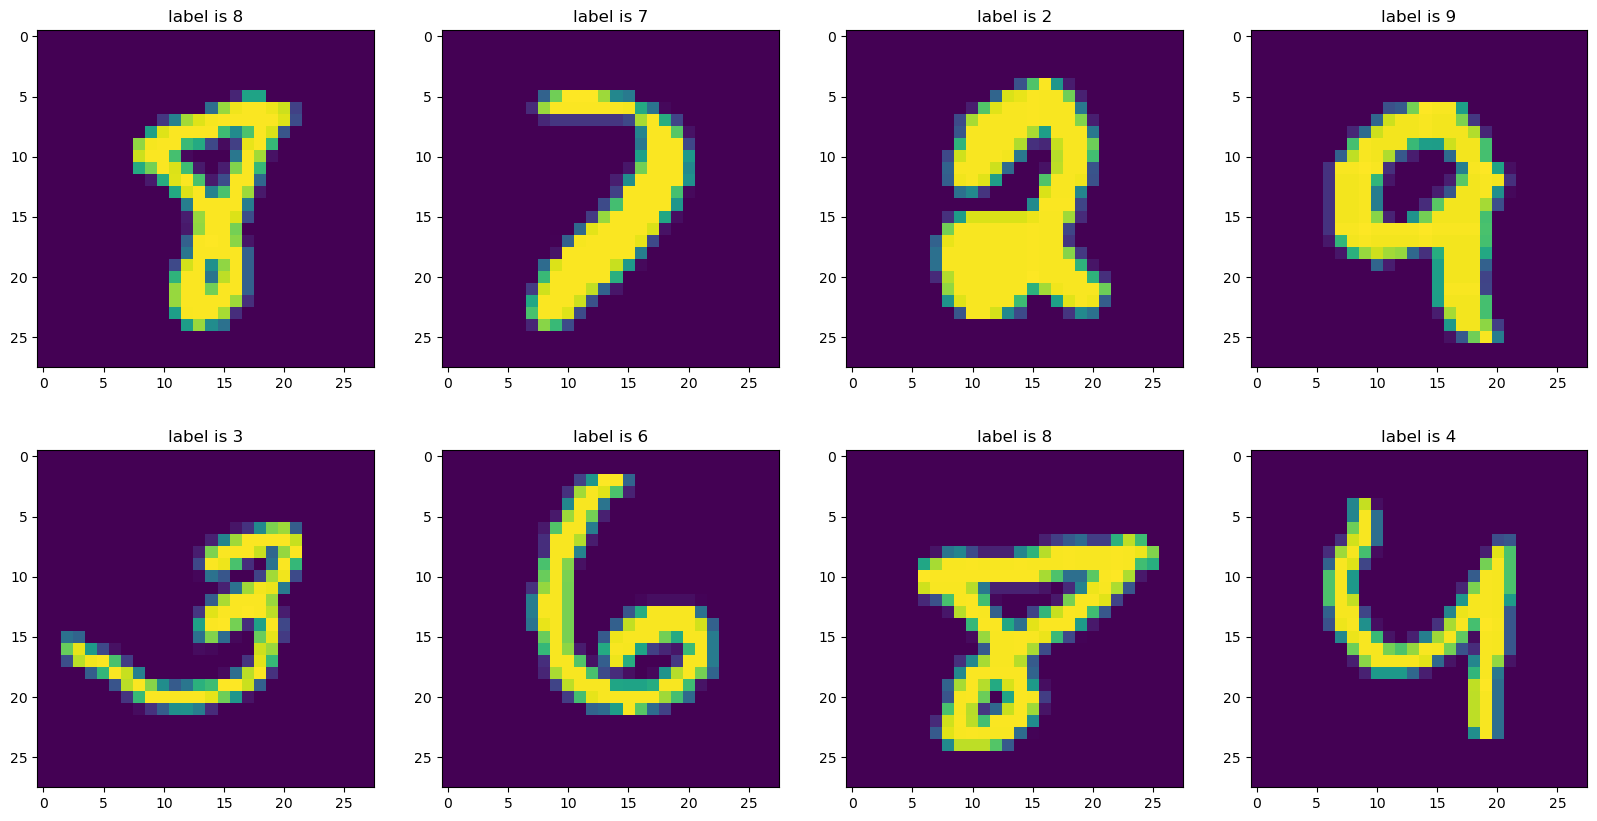

In [2]:
trainX, trainY, testX, testY = load_data()

num_train, num_feature = trainX.shape
plt.figure(1, figsize=(20,10))
for i in range(8):
    idx = np.random.choice(range(num_train))
    plt.subplot(int('24'+str(i+1)))
    plt.imshow(trainX[idx,:].reshape((28,28)))
    plt.title('label is %d'%trainY[idx])
plt.show()

In [3]:
# normalize the input value to make it between 0 and 1.
trainX, testX = trainX/255, testX/255

# convert labels to one-hot vector.
def to_onehot(y):
    y = y.astype(int)
    num_class = len(set(y))
    Y = np.eye((num_class))
    return Y[y]

trainY = to_onehot(trainY)
testY = to_onehot(testY)
num_train, num_feature = trainX.shape
num_test, _ = testX.shape
_, num_class = trainY.shape
print('number of features is %d'%num_feature)
print('number of classes is %d'%num_class)
print('number of training samples is %d'%num_train)
print('number of testing samples is %d'%num_test)
print('shape of training data is ' + str(trainX.shape))
print('shape of training data label is ' + str(trainX.shape))
print('shape of testing data is ' + str(testX.shape))
print('shape of testing data label is ' + str(testX.shape) )

number of features is 784
number of classes is 10
number of training samples is 60000
number of testing samples is 10000
shape of training data is (60000, 784)
shape of training data label is (60000, 784)
shape of testing data is (10000, 784)
shape of testing data label is (10000, 784)


In [4]:
from abc import ABC, abstractmethod, abstractproperty
class Activation(ABC):
    @abstractmethod
    def value(self, x: np.ndarray) -> np.ndarray:
        return x
    @abstractmethod
    def derivative(self, x: np.ndarray) -> np.ndarray:
        return x
class Identity(Activation):
    def __init__(self):
        super(Identity, self).__init__()
    def value(self, x: np.ndarray) -> np.ndarray:
        return x
    def derivative(self, x: np.ndarray) -> np.ndarray:
        n, m = x.shape
        return np.ones((n, m))
class Sigmoid(Activation):
    def __init__(self):
        super(Sigmoid, self).__init__()
        self.sigmoid = None 
    def value(self, x: np.ndarray) -> np.ndarray:
        x = np.clip(x, -500, 500)
        self.sigmoid = 1 / (1 + np.exp(-x))
        return self.sigmoid 
    def derivative(self, x: np.ndarray) -> np.ndarray:
        if self.sigmoid is None:
            self.value(x)
        return self.sigmoid * (1 - self.sigmoid)
class ReLU(Activation):
    def __init__(self):
        super(ReLU, self).__init__()
    def value(self, x: np.ndarray) -> np.ndarray:
        return np.maximum(0, x)
    def derivative(self, x: np.ndarray) -> np.ndarray:
        return np.heaviside(x, 0) # return 1 if x > 0, 0 otherwise
class Softmax(Activation):
    def __init__(self):
        super(Softmax, self).__init__()
        self.softmax = None # initialize the softmax value as None
    def value(self, x: np.ndarray) -> np.ndarray:
        x = x - np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x)
        sum_exp_x = np.sum(exp_x, axis=1, keepdims=True)
        self.softmax = exp_x / sum_exp_x # store the softmax value as a class attribute
        return self.softmax # return the softmax value
    def derivative(self, x: np.ndarray) -> np.ndarray:
        if self.softmax is None: # if the softmax value is not computed yet, compute it first
            self.value(x)
        return self.softmax * (1 - self.softmax) # use the stored softmax value to compute the derivative

For neural network for multi-class classification, the last layer is usually a softmax activation function. The output of the softmax function together with true targets or labels are used to compute the loss function. If both the softmax function and the loss function are computed independently, there are at least one drawbacks:

> The derivative of the softmax function w.r.t. the input is a matrix, which is not like the elementwise derivative in ReLU or sigmoid. A batch of such derivatives forms a three dimensional tensor, making the computation complicated.

To mitigate such an issue, a common trick is to merge the computation of softmax function with the loss function. In other words, the inputs to the loss function is the input to the softmax other than its output. In deep learning community, often the input to the softmax is regarded as unnormalized probability and is called logits. Being called logits is not exactly correct in math but is widely used. Let $\boldsymbol{z}$ be the logits, the output of the softmax function $\hat{\boldsymbol{y}}$ is defined as

$\hat{y}_i = \frac{e^{z_i}}{\sum_{j=1}^ke^{z_j}}, i = 1, \cdots, k$

the cross entropy loss is computed as follows:

$L(\boldsymbol{z}, \boldsymbol{y}) = \sum_{i=1}^k y_i\log(\hat{y}_i) = \sum_{i=1}^k y_i\log\left(\frac{e^{z_i}}{\sum_{j=1}^ke^{z_j}}\right) = \sum_{i=1}^k y_i z_i - \sum_{i=1}^k y_i\log(\sum_{j=1}^ke^{z_j})= \sum_{i=1}^k y_i z_i - \log(\sum_{j=1}^ke^{z_j})$

In the above expression, there is a log-sum-exponential term, which often appears in research papers and text book. The reason people prefer the log-sum-exponential term is that it is easy to deal with overflow problem. For instance, there is

$L(\boldsymbol{z}, \boldsymbol{y}) = \sum_{i=1}^k y_i z_i - \log(\sum_{j=1}^ke^{z_j}) = \sum_{i=1}^k y_i z_i - \log(\sum_{j=1}^ke^{\beta}e^{-\beta}e^{z_j})= \sum_{i=1}^k y_i z_i -\beta - \log(\sum_{j=1}^ke^{z_j-\beta})$

By letting $\beta = \max z_i$, exponential terms in the exponential expression are all negative, avoiding the overflow problem.

The derivative of the above loss function is computed as follows:

$\frac{\partial L}{\partial z_i} = y_i - \frac{e^{z_i}}{\sum_{j=1}^k e^{z_j}}$
, where the expression $\frac{e^{z_i}}{\sum_{j=1}^k e^{z_j}}$ is exactly the $i$th output of the softmax function. Thus,

$\frac{\partial L}{\partial \boldsymbol{z}} = \boldsymbol{y} - \text{softmax}(\boldsymbol{z})$

In [27]:
class Loss(ABC):
    @abstractmethod
    def value(self, yhat: np.ndarray, y: np.ndarray) -> float:
        return 0
    @abstractmethod
    def derivative(self, yhat: np.ndarray, y: np.ndarray) -> np.ndarray:
        return yhat
class CrossEntropy(Loss):
    def value(self, yhat: np.ndarray, y: np.ndarray) -> float:
        n = y.shape[0]
        loss = -np.sum(y * np.log(yhat)) / n
        return loss
    def derivative(self, yhat: np.ndarray, y: np.ndarray) -> np.ndarray:
        n = y.shape[0]
        dLdyhat = -y / (yhat * n)
        return dLdyhat

class CEwithLogit(Loss):
    def value(self, logits: np.ndarray, y: np.ndarray) -> float:
        n = y.shape[0]
        logits = logits - np.max(logits, axis=1, keepdims=True)
        exp_logits = np.exp(logits)
        sum_exp_logits = np.sum(exp_logits, axis=1, keepdims=True)
        softmax = exp_logits / sum_exp_logits
        softmax += 1e-10
        loss = -np.sum(y * np.log(softmax)) / n
        return loss
    def derivative(self, logits: np.ndarray, y: np.ndarray) -> np.ndarray:
        n = y.shape[0]
        logits = logits - np.max(logits, axis=-1, keepdims=True)
        exp_logits = np.exp(logits)
        sum_exp_logits = np.sum(exp_logits, axis=-1, keepdims=True)
        softmax = exp_logits / sum_exp_logits
        dLdz = -y + softmax
        dLdz /= n
        return dLdz

In [28]:
def accuracy(y_hat: np.ndarray, y: np.ndarray) -> float:
    y_hat_index = np.argmax(y_hat, axis=1)
    y_index = np.argmax(y, axis=1)
    equal = y_hat_index == y_index
    return np.mean(equal)

In [29]:
class NeuralNetwork():
        assert len(activation) == len(layer_size), \
        self.layer_size = layer_size
        self.num_layer = len(layer_size)
        self.activation = activation
        self.loss = loss
        self.learning_rate = learning_rate
        self.W = []
        self.b = []
        for i in range(self.num_layer-1):
            W = np.random.randn(layer_size[i], layer_size[i+1]) #/ np.sqrt(layer_size[i])
            b = np.random.randn(1, layer_size[i+1])
            self.W.append(W)
            self.b.append(b)
        self.A = []
        self.Z = []

    def forward(self, X: np.ndarray) -> (List[np.ndarray], List[np.ndarray]):
        num_sample = X.shape[0]
        A, Z = [], []
        Ai = X
        for i in range(self.num_layer-1):
            Zi = np.dot(Ai, self.W[i]) + self.b[i]
            Z.append(Zi)
            if i < self.num_layer - 1:
                Ai = self.activation[i].value(Zi)
            else:
                Ai = softmax(Zi)
            A.append(Ai)
        self.A = A
        self.Z = Z
        return Z, A

    def backward(self, dLdyhat) -> List[np.ndarray]:
        dZ = []
        for i in reversed(range(1, self.num_layer)):
            # Compute the derivative of the loss function with respect to the input of this layer using the chain rule
            if i == self.num_layer - 1:
                # Use dLdyhat as input for the last layer
                dZi = dLdyhat * self.activation[i-1].derivative(self.Z[i-1])
            else:
                # Use the previous layer's gradient as input for the next layer
                # Use self.W[i-1] instead of self.W[i] to represent the weight matrix of this layer
                dZi = dZ[self.num_layer - i - 2] @ self.W[i-1].T * self.activation[i-1].derivative(self.Z[i-1])
            # Prepend dZi to dZ
            dZ.insert(0, dZi)
        # Assign dZ to self attribute
        self.dZ = dZ
        # Return dZ
        return dZ
    
    def update_weights(self) -> List[np.ndarray]:
        #### write your code below ####
        # Loop through each layer except the first one
        for i in range(self.num_layer-1):
            # Update the weights by subtracting the product of the learning rate and the gradient of the loss function with respect to the weights
            self.W[i] -= self.learning_rate * self.A[i].T @ self.dZ[i]
            # Update the biases by subtracting the product of the learning rate and the gradient of the loss function with respect to the biases
            self.b[i] -= self.learning_rate * np.sum(self.dZ[i], axis=0, keepdims=True)
        # Return only the updated weights
        return self.W

    def one_epoch(self, X: np.ndarray,  Y: np.ndarray, batch_size: int, train: bool = True)-> (float, float):
        n = X.shape[0]
        slices = list(gen_batches(n, batch_size))
        num_batch = len(slices)
        idx = list(range(n))
        np.random.shuffle(idx)
        loss_value, acc_value = 0, 0
        for i, index in enumerate(slices):
            index = idx[slices[i]]
            x, y = X[index,:], Y[index]
            Z, A = self.forward(x)   
            yhat = A[-1]
            if train:
                # Use self.Z[-1] instead of z to represent the input of the last layer
                dLdz = self.loss.derivative(self.Z[-1], y)         
                self.backward(dLdz)     
                self.update_weights()  
            loss_value += self.loss.value(yhat, y)*x.shape[0]
            acc_value += accuracy(yhat, y)*x.shape[0]
        loss_value = loss_value/n
        acc_value = acc_value/n
        return loss_value, acc_value

In [30]:
def train(model : NeuralNetwork, X: np.ndarray, Y: np.ndarray, batch_size: int, epoches: int) -> (List[np.ndarray], List[float]):
    loss_value, acc = model.one_epoch(X, Y, batch_size, train = False)
    epoch_loss, epoch_acc = [loss_value], [acc]
    print('Initialization: ', 'loss %.4f  '%loss_value, 'accuracy %.2f'%acc)
    for epoch in range(epoches):
        if epoch%100 == 0 and epoch > 0: # decrease the learning rate
            model.learning_rate = min(model.learning_rate/10, 1.0e-5)
        loss_value, acc = model.one_epoch(X, Y, batch_size, train = True)
        if epoch%1 == 0:
            print("Epoch {}/{}: Loss={}, Accuracy={}".format(epoch, epoches, loss_value, acc))
        epoch_loss.append(loss_value)
        epoch_acc.append(acc)
    return epoch_loss, epoch_acc

In [31]:
print("输入数据形状：", testX.shape)
print("输出数据形状：", testY.shape)
num_sample, num_feature = trainX.shape
epoches = 3
batch_size = 512
Loss = []
Acc = []
learning_rate = 1/num_sample*batch_size
np.random.seed(2023)
model = NeuralNetwork([784, 256, 64, 10], [Identity(), ReLU(), ReLU(), Softmax()], CEwithLogit(), learning_rate = learning_rate)
epoch_loss, epoch_acc = train(model, trainX, trainY, batch_size, epoches)

# testing procedure
test_loss, test_acc = model.one_epoch(testX, testY, batch_size, train = False)
z, yhat = model.forward(testX)
yhat = np.argmax(yhat, axis = 1)
y = np.argmax(testY, axis = 1)
print(confusion_matrix(yhat, y))
print(classification_report(yhat, y))

输入数据形状： (10000, 784)
输出数据形状： (10000, 10)
Initialization:  loss 20.3859   accuracy 0.11


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 64 is different from 10)